<a href="https://colab.research.google.com/github/shantanu812/MLProjects/blob/main/MNISTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X,y=mnist['data'],mnist['target']
X.shape
y.shape

(70000,)

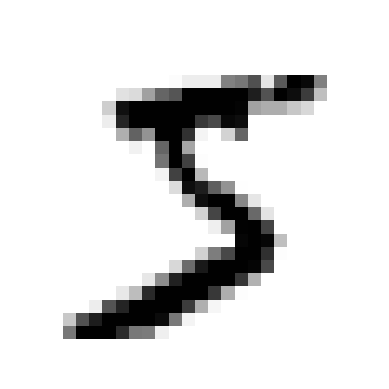

Actual Number:  5


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
print('Actual Number: ',y[0])

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
#shuffling of training dataset
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
print(y_train[:10])

['8' '4' '5' '2' '0' '8' '2' '0' '6' '1']


In [ ]:
#binary classifier for number 5
y_train_5 = (y_train == '5')#boolean array
y_test_5 = (y_test == '5')
y_train_5[y_train_5==True]

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
#SGD Classifier for training
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#accuracy is not good measure because over 90% values are not-5 and a dumb classifier would score 90% accuracy

array([0.9644, 0.9657, 0.9639])

In [ ]:
#confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53986,   593],
       [ 1527,  3894]])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
#f1 score harmonic mean of precision and recall
print(f1_score(y_train_5, y_train_pred))

0.8678404279028304
0.7183176535694521
0.7860314897052887


In [ ]:
#precision and recall are inversely proportional
#decision function and thresholds
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

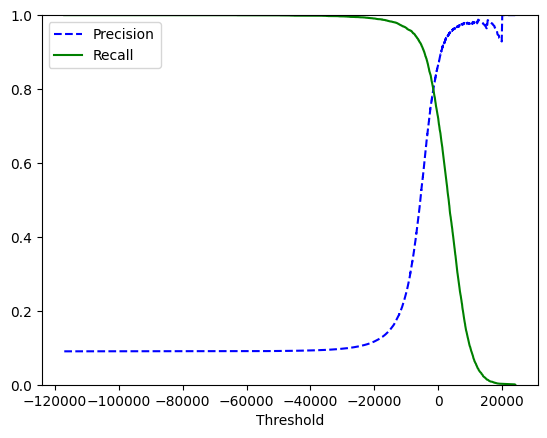

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#precision increases with threshold and recall decreases

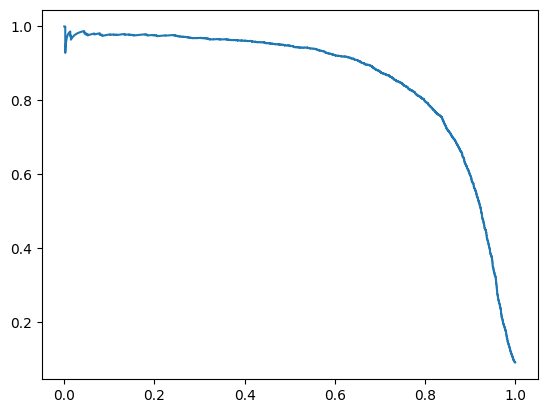

In [ ]:
plt.plot(recalls[:-1],precisions[:-1])
plt.show()

In [ ]:
y_train_pred_90 = (y_scores > 2500)#2500 is the threshold
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9398307740520213
0.5532189632909057


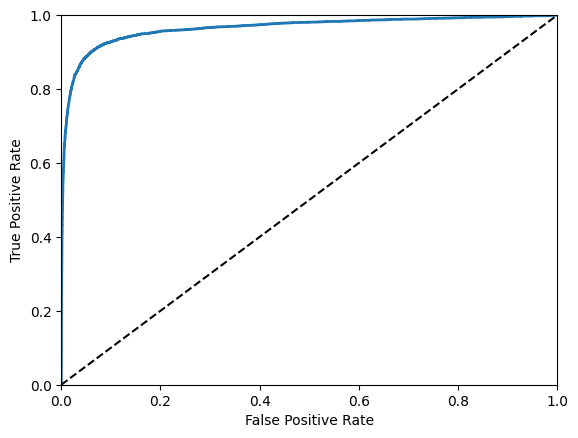

In [ ]:
#ROC curve (recall Vs FPR)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
#area under curve(AUC)
#perfect classifier - 1
#random classifier - 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9649754575749909)


*   When you care about false positives - PR curve
*   otherwise ROC curve
*   in this case,ROC gives good results as most are not-5
*   but in PR curve shows that there is a room of improvement

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")


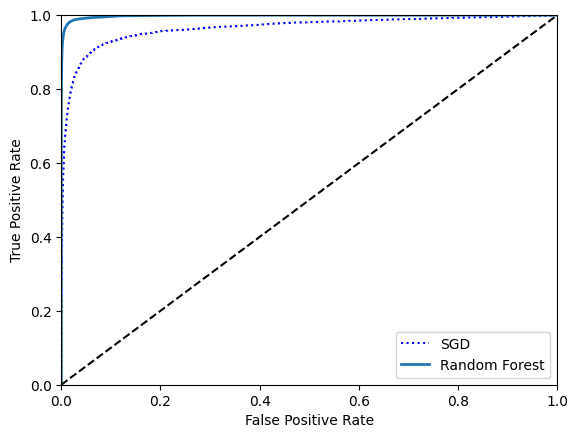

0.9982810414797261


In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()
plt.show()
print(roc_auc_score(y_train_5, y_scores_forest))

In [ ]:
#multiclass classification
#one vs all strategy
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores#max score is for 5

array([[-14365.30370669, -46756.60671492,  -6710.62284889,
          -189.73726587, -16985.06759874,   -852.89269676,
        -24648.81014523, -11834.79688745,  -7824.75357725,
        -13955.94430794]])


####OneVsOne strategy
```
 from sklearn.multiclass import OneVsOneClassifier
 ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
 ovo_clf.fit(X_train, y_train)
 ovo_clf.predict([some_digit])
 output - array([ 5.])
```



In [ ]:
#using scaling to increase accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
#error analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#multilabel classification
from sklearn.neighbors import KNeighborsClassifier
y_train_num=y_train.astype(np.uint8)
y_train_large = (y_train_num >= 7)
y_train_odd = (y_train_num % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])



```
>>> y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
>>> f1_score(y_train, y_train_knn_pred, average="macro")#average='weighted' for imbalance
0.96845540180280221
```



In [ ]:
#multioutput classification
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

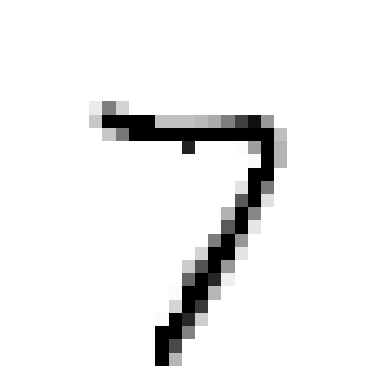

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
clean_digit=clean_digit.reshape(28,28)
plt.imshow(clean_digit,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()